# **Covid-19 Spread Model at University of Virginia**

Goal: simulate virus spread in a student population at the university of virginia. Agents will move randomly on an on-lattice grid and infected individuals have the ability to spread infection to susceptible individuals.

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [62]:
import skimage
import skimage.io
import skimage.viewer
import skimage.color
from skimage.measure import label, regionprops, regionprops_table

# Locations of UVA Buildings

In [63]:
# Global Variables:
job_list = ["Thornton","Rotunda","UVA Health","Nau Hall","Minor Hall","Mcintire"]
house_list = ["McCormick","Alderman","Dungle-Jungle","Gooch-Dillard"]
leisure_list = ["Clem","Clark","Corner","Mad Bowl"]

locations = {'Thornton': [9,7], 'Rotunda': [5,14], 'UVA Health': [12,16], 'Nau Hall': [11,13], 'Minor Hall': [8,12], 'Mcintire': [10,14]}
leisure = {'Clem':[5,11],'Clark':[8,10],'Corner': [6,15],'Mad Bowl':[3,14]}
houses = {'McCormick':[6,6],"Alderman":[8,3],"Dungle-Jungle":[10,1], "Gooch-Dillard":[15,1]}

for k in locations.keys():
    locations[k] = tuple([i*6 for i in locations[k]])

for k in leisure.keys():
    leisure[k] = tuple([i*6 for i in leisure[k]])
    
for k in houses.keys():
    houses[k] = tuple([i*6 for i in houses[k]]) 

density_threshold = 178/2500;
mask_advantage = 0.1
all_infected = 0 
time = 0;
prob_infection = 1 - 0.8
prob_recovery = 0.68

In [64]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook, push_notebook
from bokeh.models import HoverTool

In [65]:
def dict_to_df(df):
    source = pd.DataFrame(df)
    source = source.T
    source["Name"] = source.index
    source.index = range(len(source.index))
    source.columns = ["x","y","Name"]
    return source

In [66]:
# create a new bokeh plot that is representative of the 100 x 100 grid agents 
# will be moving on

output_notebook()
p = figure(x_range=(0, 100), y_range=(0, 100))

source_locations = ColumnDataSource(dict_to_df(locations))
source_leisure = ColumnDataSource(dict_to_df(leisure))
source_houses = ColumnDataSource(dict_to_df(houses))

p.square('x', 'y',source=source_locations, size=20, fill_color="navy", fill_alpha=0.3, line_color=None)
p.square('x', 'y',source=source_leisure, size=20, fill_color="green", fill_alpha=0.3, line_color=None)
p.square('x', 'y',source=source_houses, size=20, fill_color="orange", fill_alpha=0.3, line_color=None)

my_hover = HoverTool()
my_hover.tooltips = [('Building','@Name')]
p.add_tools(my_hover)


show(p)

Loading BokehJS ...

# Model Implementation

In [67]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from scipy.spatial import distance
import matplotlib.pyplot as plt

In [158]:
# Model with quarantine implementation.
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from scipy.spatial import distance
import matplotlib.pyplot as plt

class Individual(Agent):
  #age,health,job
    def __init__(self,unique_id,model,infected,house,mask,responsible): # incubation period? 
        super().__init__(unique_id,model)

        # list of jobs students can have and the probability they are that student
        self.infected = infected
        self.job = np.random.choice(job_list)
        self.home = house
        self.leisure = np.random.choice(leisure_list)
        if self.infected == 1:
            self.time_infected = 0
        else:
            self.time_infected = -1
        #instantiate private variables like age, pre-existing conditions...
        self.mask = mask
        self.responsible = responsible
  
    def step(self):
        if (self.model.time % 96) == 72:
            self.leisure = np.random.choice(leisure_list)
        self.move()
        
        if self.infected == 0:
            if (self.model.time % 96) < 40 and self.pos != houses[self.home]:
                self.move()
            if (self.model.time % 96) >= 40 and (self.model.time%96) < 56:
#                 print("im here")
                if self.pos != locations[self.job]:
#                     print(" gonna move")
                    self.move()
            if (self.model.time % 96) >= 56 and (self.model.time%96) < 72:
                if self.pos != houses[self.home]:
                    self.move()
            if (self.model.time % 96) >= 72:
                if self.pos != leisure[self.leisure]:
                    self.move()       
        else:
            if self.model.quarantine == True:
                if self.pos != (20,20):
                    self.move()
            else:
                if self.pos != houses[self.home]:
                    self.move()
                    
        if self.infected == 1:
            self.time_infected = self.time_infected + 1;
            if self.time_infected > 48 and self.time_infected < 480:
                self.infect()
            self.recover()
    
    def move(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore = True, radius = 5, include_center = False)
        #not sure what we wanna do w/ the grid size. Grounds is 1.8 miles^2 = ~50 mil ft^2. if each patch is 100x100 ft, we have 5000 patches
        grid_size = 5000 #100 ft x 100 ft patch (is that too big?)
        densities = []
        dictionary = {}
        
        if self.infected == 0:
            if (self.model.time % 96) < 40:
                destination = houses[self.home]
            if (self.model.time % 96) >= 40 and (self.model.time%96) < 56:
                destination = locations[self.job]
            if (self.model.time % 96) >= 56 and (self.model.time%96) < 72:
                destination = houses[self.home]
            if (self.model.time % 96) >= 72:
                destination = leisure[self.leisure]
        else:
            if self.model.quarantine == True:
                p = np.random.random()
                if p < 0.8:
                    destination = (20,20)
                else:
                    destination = houses[self.home]
            else:
                destination = houses[self.home]
            
        distances = [distance.euclidean(i,destination) for i in neighbors]  
        densities = [len(self.model.grid.get_cell_list_contents([n])) / grid_size for n in neighbors]
        viable_patches = [i < density_threshold for i in densities]
        min_index = 0
        
        if self.infected == 0:
            if sum(viable_patches) > 0:
                for i in range(len(distances)):
                    if viable_patches[i] ==  True and distances[i] < distances[min_index]:
                        min_index = i;
            else:
                if responsible == 1:
                    min_index = np.argmin(densities)
                else:
                    min_index = np.argmin(distances)
        else:
            min_index = np.argmin(distances)
        new_position = neighbors[min_index]
        self.model.grid.move_agent(self, new_position)
        
    def infect(self):
        num_mask = 0;
        num_infected = 0;
        if self.infected == 1:
            people = self.model.grid.get_cell_list_contents([self.pos])
            density = len(people) / 5000
            for i in people:
                p = np.random.random()
                if i.infected == 0:
                    if (self.model.time % 96) < 40 and p < 0.05:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 40 and (self.model.time%96) < 56 and p < 0.1:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 56 and (self.model.time%96) < 72 and p < 0.05:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 72 and p < 0.5:
                        i.infected = 1
                        i.time_infected = 0

    def recover(self):
        p = np.random.random()
        if self.infected == 1:
            if (self.time_infected) > 96:
                if p < prob_recovery:
                    self.infected = 0;
                    self.time_infected = -1
        

class CovidModel(Model):
    def __init__(self,N,width,height,initial_infected,p_mask, p_responsible,quarantine):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width,height,True)
        self.schedule = RandomActivation(self)
        self.time = 0
        self.quarantine = quarantine
        
        for i in range(N):
            p = np.random.random()
            mask_i = 0;
            responsible_i = 0;
            infected_i = 0;
            
            if p < p_mask:
                mask_i = 1;
            if p < p_responsible:
                responsible_i = 1;
            if i < initial_infected:
                infected_i = 1
            
            house_i = np.random.choice(house_list)
            
            a = Individual(i,self,infected_i, house_i, mask_i,responsible_i)
            self.schedule.add(a)
            
            loc = houses[house_i]
            self.grid.place_agent(a,(loc))
            
        self.datacollector = DataCollector(
          model_reporters = {"Number_Infected": calc_num_infected},
          agent_reporters = {"Infection_Status": "infected"}
        )
#         print("finished")
   
    def step(self):
        self.schedule.step()
        self.time = self.time + 1
        self.datacollector.collect(self)
        

def calc_num_infected(model):
    return sum(a.infected for a in model.schedule.agents)

# Methods for Model Visualization

In [159]:
from bokeh.transform import transform
from bokeh.models import ColumnDataSource, BasicTicker, CategoricalTicker, LinearColorMapper

In [165]:
def update_agents_data(agents):
    new_data = {}
    agents_positions = np.array([agent.pos for agent in agents])
    new_data['x'] = np.array([pos[0] for pos in agents_positions])
    new_data['y'] = np.array([pos[1] for pos in agents_positions])
    new_data['infected'] = np.array([agent.infected for agent in agents])
    return new_data

In [166]:
def show_agents(agent_positions):
    p = figure(x_range=(0, 100), y_range=(0, 100))

    source_locations = ColumnDataSource(dict_to_df(locations))
    source_leisure = ColumnDataSource(dict_to_df(leisure))
    source_houses = ColumnDataSource(dict_to_df(houses))

    p.square('x', 'y',source=source_locations, size=20, fill_color="navy", fill_alpha=0.3, line_color=None)
    p.square('x', 'y',source=source_leisure, size=20, fill_color="green", fill_alpha=0.3, line_color=None)
    p.square('x', 'y',source=source_houses, size=20, fill_color="orange", fill_alpha=0.3, line_color=None)

    my_hover = HoverTool()
    my_hover.tooltips = [('Building','@Name')]
    p.add_tools(my_hover)
    
    colors = ['green', 'red']
    mapper = LinearColorMapper(palette=colors, 
                               low=0, 
                               high=1)

    p.circle(x='x', y='y', radius = 0.5, source=agent_positions,alpha = 0.3,
       line_color=None, fill_color=transform('infected', mapper))
    
    p.grid.grid_line_color = None    
    p.axis.axis_line_color = None
    p.toolbar.logo = None
    
    show(p,notebook_handle=True)

# Running the Model

In [179]:
model = CovidModel(100, 100, 100,3,.8,.8,False)
agent_positions = ColumnDataSource(update_agents_data(model.schedule.agents))
show_agents(agent_positions)

for i in range(105):
    model.step()
#     if i % 10 == 0:
    agent_positions.data = (update_agents_data(model.schedule.agents))
    push_notebook()

In [176]:
model = CovidModel(100, 100, 100,5,.8,.8,True)
agent_positions = ColumnDataSource(update_agents_data(model.schedule.agents))

TypeError: 'ColumnDataSource' object is not subscriptable

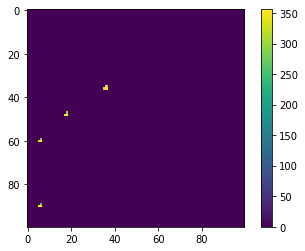

In [119]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts,interpolation='nearest')
plt.colorbar()

# Batchrunner!

In [9]:
import multiprocessing
import time

In [10]:
# define a function for parameter space exploration of mask mandate.
def explore_param_mask(p_mask):
    print("i got here yo")
    model = CovidModel(4000, 100, 100,100,p_mask,.8)
    for i in range(0,1000):
        model.step()
    return model.datacollector.get_model_vars_dataframe()

In [ ]:
def fixed_run_model(i):
    print(i)
    model = CovidModel(4000, 100, 100,100,0.8,.8)
    for k in range(0,1000):
        model.step()
    df = model.datacollector.get_model_vars_dataframe()
    print("finished")
    return {i: df}

In [11]:
if __name__ == '__main__':
    pool = multiprocessing.Pool()
    pool = multiprocessing.Pool(processes=4)
    inputs = [0,0.2,0.4,0.6,0.8,1]
    outputs = pool.map(explore_param_mask,inputs)

i got here yo
i got here yo
i got here yo
i got here yo
i got here yo
i got here yo


Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-1:
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/usr/local/Cellar/

,Number_Infected
0,479
1,855
2,936
3,942
4,935
5,944
6,950
7,944
8,936
9,947


# Run the Quarantine Model

In [31]:
class Individual(Agent):
  #age,health,job
    def __init__(self,unique_id,model,infected,house,mask,responsible): # incubation period? 
        super().__init__(unique_id,model)

        # list of jobs students can have and the probability they are that student
        self.infected = infected
        self.job = np.random.choice(job_list)
        self.home = house
        if self.infected == 0:
            self.time_infected = 0
        else:
            self.time_infected = -1
        #instantiate private variables like age, pre-existing conditions...
        self.mask = mask
        self.responsible = responsible
  
    def step(self):
        self.move()
        if self.infected == 1:
            self.infect()
            self.time_infected = self.time_infected + 1;
            self.recover()
            
    def move(self):
        neighbors = self.model.grid.get_neighborhood(self.pos, moore = True, include_center = False, radius=5)
    # not sure what we wanna do w/ the grid size. Grounds is 1.8 miles^2 = ~50 mil ft^2. 
    # if each patch is 100x100 ft, we have 5000 patches
        grid_size = 5000 #100 ft x 100 ft patch (is that too big?)
        densities = []
        dictionary = {}
        
        if self.infected == 0:
            if (self.model.time % 96) < 40:
                destination = tuple([k*6 for k in houses[self.home]])
            if (self.model.time % 96) >= 40 and (self.model.time%96) < 56:
    #             print("im here")
                destination = tuple([k*6 for k in locations[self.job]])
            if (self.model.time % 96) >= 56 and (self.model.time%96) < 72:
                destination = tuple([k*6 for k in houses[self.home]])
            if (self.model.time % 96) >= 72:
                l = np.random.choice(leisure_list)
                destination = tuple([k*6 for k in leisure[l]])
                
        p = np.random.random()
        if self.infected == 1:
            if p < 0.8:
                destination = (20,20)
            else:
                destination = tuple([k*6 for k in houses[self.home]])
            
        distances = [distance.euclidean(i,destination) for i in neighbors]
        densities = [len(self.model.grid.get_cell_list_contents([n])) / grid_size for n in neighbors]
        viable_patches = [i < density_threshold for i in densities]
        min_index = 0
        if sum(viable_patches) > 0:
            for i in range(len(distances)):
                if viable_patches[i] ==  True and distances[i] < distances[min_index]:
                    min_index = i;
            min_index
        else:
            if responsible == 1:
                min_index = np.argmin(densities)
            else:
                min_index = np.argmin(distances)
        new_position = neighbors[min_index]
        self.model.grid.move_agent(self, new_position)
        
    def infect(self):
        num_mask = 0;
        num_infected = 0;
        if self.infected == 1:
            people = self.model.grid.get_cell_list_contents([self.pos])
            density = len(people) / 5000
            for i in people:
                p = np.random.random()
                if i.infected == 0:
                    if (self.model.time % 96) < 40 and p < 0.05:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 40 and (self.model.time%96) < 56 and p < 0.1:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 56 and (self.model.time%96) < 72 and p < 0.05:
                        i.infected = 1
                        i.time_infected = 0
                    if (self.model.time % 96) >= 72 and p < 0.5:
                        i.infected = 1
                        i.time_infected = 0

    def recover(self):
        p = np.random.random()
        if self.infected == 1:
#             if (self.time_infected / 24) > 10:
            if p < prob_recovery:
#                 print("recovrerd!")
                self.infected = 0;
                self.time_infected = -1
        

class CovidModel_with_Quarantine(Model):
    def __init__(self,N,width,height,initial_infected,p_mask, p_responsible):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width,height,True)
        self.schedule = RandomActivation(self)
        self.time = 0
        
        for i in range(N):
            p = np.random.random()
            mask_i = 0;
            responsible_i = 0;
            infected_i = 0;
            
            if p < p_mask:
                mask_i = 1;
            if p < p_responsible:
                responsible_i = 1;
            if i < initial_infected:
                infected_i = 1
            
            house_i = np.random.choice(house_list)
            
            a = Individual(i,self,infected_i, house_i, mask_i,responsible_i)
            self.schedule.add(a)
            
#             x = self.random.randrange(self.grid.width)
#             y = self.random.randrange(self.grid.height)
#             print(houses[house_i])
            loc = tuple([k*6 for k in houses[house_i]])
            self.grid.place_agent(a,(loc))
            
        self.datacollector = DataCollector(
          model_reporters = {"Number_Infected": calc_num_infected},
          agent_reporters = {"Infection_Status": "infected", "Position": "pos"}
        )
#         print("finished")
   
    def step(self):
        self.schedule.step()
        self.time = self.time + 1
        self.datacollector.collect(self)
        

def calc_num_infected(model):
    return sum(a.infected for a in model.schedule.agents)

In [32]:
model = CovidModel_with_Quarantine(100, 100, 100,100,.8,.8)
agent_positions = ColumnDataSource(update_agents_data(model.schedule.agents))
show_agents(agent_positions)

for i in range(1000):
    model.step()
    if i % 5 == 0:
        agent_positions.data = (update_agents_data(model.schedule.agents))
        push_notebook()

KeyboardInterrupt: 

In [ ]:
def run_model(row):
    r = []
    for i in row:
        model = CovidModel_with_Quarantine(100, 100, 100,100,x,.8)
        for k in range(100):
            model.step()
        r.append(model.datacollector.get_model_vars_dataframe())
    return r

In [ ]:
[print(i) for i in data]

In [ ]:
arr = np.random.randint(0, 1, size=[2, 3])
data = arr.tolist()
data

In [ ]:
import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())
results = [pool.apply(run_model, args=(row)) for row in [[0.2,0.4,0.6],[0.2,0.4,0.6]]]
pool.close()

In [ ]:
import pathos
from mesa.batchrunner import BatchRunner, BatchRunnerMP

variable_params = {"p_mask": [0,0.2,0.4,0.6,0.8,1]}
fixed_params = {"N": 4000,"height": 100,"width" : 100,"initial_infected" : 100,"p_responsible": 0.8}
batch_run = BatchRunnerMP(
    CovidModel,
    nr_processes=4,
    variable_parameters=variable_params,
    fixed_parameters=fixed_params,
    iterations=10,
    max_steps=1000,
    model_reporters = {"Number_Infected": calc_num_infected}
)
batch_run.run_all()

In [ ]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts,interpolation='nearest')
plt.colorbar()

model = CovidModel(4000, 100, 100,100,.8,.8)
for i in range(1000):
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    
    model.step()

In [ ]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer

def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Color": "red",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    if agent.infected == 0:
        portrayal["Color"] = "blue"
        portrayal["Layer"] = 0
        portrayal["r"] = 0.5
    else:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal

grid = CanvasGrid(agent_portrayal, 100, 100, 1000, 1000)
server = ModularServer(CovidModel,
                       [grid],
                       "Covid Model",
                       {"N":4000, "width":100, "height":100,"initial_infected":100,
                        "p_mask":0.9, "p_responsible":0.9})
server.port = 8521 # The default
server.launch()

# Creating the Map

In [ ]:
from bokeh.plotting import figure, save
p = figure(title="My first interactive plot!")
p

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [ ]:
# Get longitude + latitude of UVA locations.

locations = pd.DataFrame({'Buildings': ["Thornton","Rotunda","UVA Health","Nau Hall","Minor Hall","Mcintire"],
                'Latitude':[38.033315,38.035577,38.031218683072424,38.03174035832428,38.0340720900789,38.032985182256795],
                'Longitude': [-78.509628,-78.503437,-78.49885468894693,-78.50500573127624,-78.50649113127622,-78.50383663127617]
            })

In [ ]:
gdf = gpd.GeoDataFrame(
    locations, geometry=gpd.points_from_xy(locations.Longitude, locations.Latitude))
gdf.head()

In [ ]:
gpd.datasets.available

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
world
ax = world[world.name == 'Charlottesville'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

In [ ]:
src = "ABMSociety_Covid19/structure_existing_area/structure_existing_area_09_03_2020.shp"

In [ ]:
points = gpd.read_file(src)
points["NAME"] == "None"

In [ ]:
points = gpd.read_file("VirginiaBuildingFootprint/VirginiaBuildingFootprint.shp")